In [1]:
# import necessary packages
import os
import numpy as np
from numpy import random
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt

# set seed to ensure reproducibility
SEED = 8
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [2]:
class MLP:
    def __init__(self, lr=1e-3, num_epochs=10, l1_weight=0, l2_weight=0):
        self.lr = lr
        self.num_epochs = num_epochs
        self.l1_weight = l1_weight
        self.l2_weight = l2_weight
        self.train_loss = []
        self.test_accuracy = []
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28 * 1, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
            )
        self.model.cuda()
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr)  

    def fit(self, trainloader, testloader):

        for epoch in range(self.num_epochs):
            print(f'Starting epoch {epoch+1}')
            # iterate over the dataLoader for training data
            for i, data in enumerate(trainloader, 0):  
                # get inputs
                X_train, y_train = data
                # send to GPU if available
                X_train, y_train = Variable(X_train).cuda(), Variable(y_train).cuda()
                # zero the gradients
                self.optimizer.zero_grad()
                # perform forward pass
                y_predicted = self.model(X_train)
                # compute loss
                loss_train = self.criterion(y_predicted, y_train)

                # Add L1 loss component
                if self.l1_weight != 0:
                    l1_parameters = []
                    for parameter in self.model.parameters():
                        l1_parameters.append(parameter.view(-1))
                    l1 = self.l1_weight * self.compute_l1_loss(torch.cat(l1_parameters))
                    loss_train += l1

                # Add L2 loss component
                if self.l2_weight != 0:
                    l2_parameters = []
                    for parameter in self.model.parameters():
                        l2_parameters.append(parameter.view(-1))
                    l2 = self.l2_weight * self.compute_l2_loss(torch.cat(l2_parameters))
                    loss_train += l2

                # perform backward pass
                loss_train.backward()
                # perform optimization
                self.optimizer.step()
                # add training loss
                self.train_loss.append(loss_train.item())

            # get test set performance
            with torch.no_grad():
                X_test, y_test = iter(testloader).next()
                X_test = X_test.cuda()
                y_test_pred = self.predict(X_test)
                # get predictions for the test set
                y_test_pred = self.predict(X_test).cpu()
                # store test set accuracy
                self.test_accuracy.append(np.mean((y_test == y_test_pred).numpy()))
                print('Test accuracy: {}'.format(self.test_accuracy[-1]))

        return self

    # make class predictions for test set
    def predict(self, x):
        model = self.model.eval()
        outputs = model(Variable(x))
        _, pred = torch.max(outputs.data, 1)
        model = self.model.train()
        return pred
    
    def compute_l1_loss(self, w):
      return torch.abs(w).sum()

    def compute_l2_loss(self, w):
      return torch.square(w).sum()

In [3]:
# Prepare CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]) 
trainset = MNIST(root='data/', train=True, download=True, transform=transform) 
testset = MNIST(root='data/', train=False, transform=transform) 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# set optimization device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model configuration and initialization
model_list = [MLP(num_epochs=50, l1_weight=0, l2_weight=0), 
        MLP(num_epochs=50, l1_weight=0.001, l2_weight=0),
        MLP(num_epochs=50, l1_weight=0, l2_weight=0.001),
        MLP(num_epochs=50, l1_weight=0.001, l2_weight=0.001)]

# start training
[tmp_model.fit(trainloader, testloader) for tmp_model in model_list]

Starting epoch 1
Test accuracy: 0.2148
Starting epoch 2
Test accuracy: 0.4223
Starting epoch 3
Test accuracy: 0.5263
Starting epoch 4
Test accuracy: 0.5363
Starting epoch 5
Test accuracy: 0.5939
Starting epoch 6
Test accuracy: 0.6575
Starting epoch 7
Test accuracy: 0.7179
Starting epoch 8
Test accuracy: 0.7578
Starting epoch 9
Test accuracy: 0.783
Starting epoch 10
Test accuracy: 0.8017
Starting epoch 11
Test accuracy: 0.8143
Starting epoch 12
Test accuracy: 0.8241
Starting epoch 13
Test accuracy: 0.8337
Starting epoch 14
Test accuracy: 0.841
Starting epoch 15
Test accuracy: 0.849
Starting epoch 16
Test accuracy: 0.8547
Starting epoch 17
Test accuracy: 0.8593
Starting epoch 18
Test accuracy: 0.8645
Starting epoch 19
Test accuracy: 0.8674
Starting epoch 20
Test accuracy: 0.8707
Starting epoch 21
Test accuracy: 0.8746
Starting epoch 22
Test accuracy: 0.8765
Starting epoch 23
Test accuracy: 0.8814
Starting epoch 24
Test accuracy: 0.8832
Starting epoch 25
Test accuracy: 0.886
Starting epoc

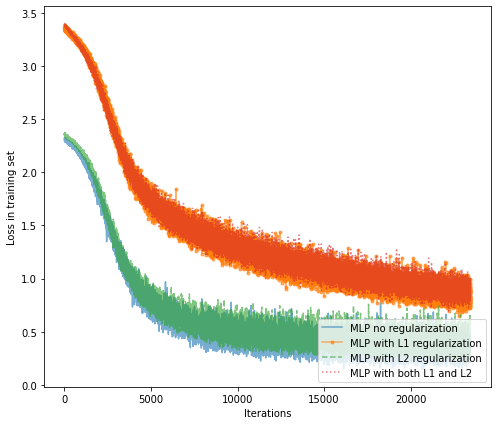

In [7]:
mlp_train_loss = np.array([tmp_model.train_loss for tmp_model in model_list])

labels = ['MLP no regularization', 
          'MLP with L1 regularization', 
          'MLP with L2 regularization', 
          'MLP with both L1 and L2']
styles = ['-', '.-', '--', ':']
plt.figure(figsize=(8, 7))
for i, r in enumerate(mlp_train_loss):
    plt.plot(np.array(range(1, len(r)+1)), r, styles[i], label=labels[i], alpha=0.6);
plt.legend(loc=4);
plt.xlabel('Iterations');
plt.ylabel('Loss in training set');
plt.show()

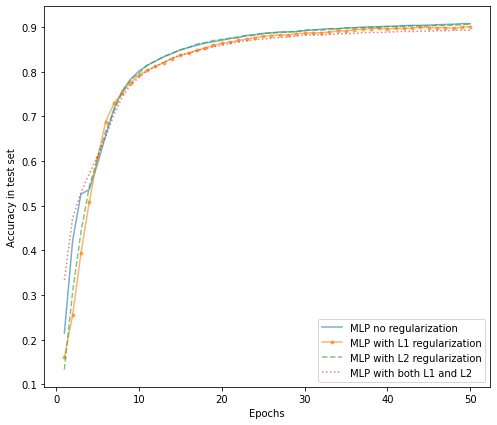

In [6]:
mlp_test_accuracy = np.array([tmp_model.test_accuracy for tmp_model in model_list])

labels = ['MLP no regularization', 
          'MLP with L1 regularization', 
          'MLP with L2 regularization', 
          'MLP with both L1 and L2']
styles = ['-', '.-', '--', ':']
plt.figure(figsize=(8, 7))
for i, r in enumerate(mlp_test_accuracy):
    plt.plot(np.array(range(1, len(r)+1)), r, styles[i], label=labels[i], alpha=0.6);
plt.legend(loc=4);
plt.xlabel('Epochs');
plt.ylabel('Accuracy in test set');
plt.show()